## Assignment 3

1. Answer 
  1. I used the poem 'the cat in the hat' for training my RNN.
  2. I obtained the one hot encoding for each character to input to the RNN.

In [17]:
import numpy as np
np.random.seed(5)

from datetime import datetime
import sys

def softmax(x, t=1):
    xt = np.exp(x/t)
    if np.sum(xt) == 0:
        print(np.sum(xt))
    return xt / np.sum(xt)

def ohe(c):
    v = np.zeros(256, dtype=np.int8)
    if (ord(c) > 255):
        return v
    v[ord(c)] = 1
    return v

The below program converts all the characters in the poem to its corresponding one hot encoding.

In [21]:
ohes = []
asciis = []

with open("poem.txt") as f:
    while True:
        c = f.read(1)
        if not c:
            break
        else:
            ohes.append(ohe(c))
#             asciis.append(np.array([ord(c)]))

ohes = np.array(ohes)
# asciis = np.array(asciis)
# print(np.shape(asciis))

def get_train_data(k=20):

    X_train = []
    y_train = []
    for i in range(0,len(ohes)-k-1,5):
        X_train.append(ohes[i:i+k])
        y_train.append(ohes[i+1:i+k+1])

    X_train = np.array(X_train)
    y_train = np.array(y_train)
    return X_train, y_train

X_train, y_train = get_train_data()

print(X_train.shape, y_train.shape)

(375, 20, 256) (375, 20, 256)


## Answer 2b

The following is the program used to train RNN. I have used the program given at
[WILDML](http://www.wildml.com/2015/09/recurrent-neural-networks-tutorial-part-2-implementing-a-language-model-rnn-with-python-numpy-and-theano/) and changed a bit to take input one hot encodings of the charcters.

In [31]:
class RNN:
    def __init__(self, word_dim, hidden_dim=100, bptt_truncate=10):
        self.word_dim = word_dim
        self.hidden_dim = hidden_dim
        self.bptt_truncate = bptt_truncate
        
        self.U = np.random.uniform(-np.sqrt(1./word_dim), np.sqrt(1./word_dim), (hidden_dim, word_dim))
        self.V = np.random.uniform(-np.sqrt(1./hidden_dim), np.sqrt(1./hidden_dim), (word_dim, hidden_dim))
        self.W = np.random.uniform(-np.sqrt(1./hidden_dim), np.sqrt(1./hidden_dim), (hidden_dim, hidden_dim))
        
    def forward_propagation(self, x, temp=1):
        # The total number of time steps
        T = len(x)
        # During forward propagation we save all hidden states in s because need them later.
        # We add one additional element for the initial hidden, which we set to 0
        s = np.zeros((T + 1, self.hidden_dim))
        s[-1] = np.zeros(self.hidden_dim)
        # The outputs at each time step. Again, we save them for later.
        o = np.zeros((T, self.word_dim))
        # For each time step...
        for t in np.arange(T):
            # Note that we are indxing U by x[t]. This is the same as multiplying U with a one-hot vector.
            # print(x.shape, s.shape)
#             s[t] = np.tanh(self.U[:,x[t]] + self.W.dot(s[t-1]))
            s[t] = np.tanh(self.U.dot(x[t]) + self.W.dot(s[t-1]))
            o[t] = softmax(self.V.dot(s[t]), temp)
        return [o, s]
    
    def predict(self, x, temp):
        # Perform forward propagation and return index of the highest score
        o, s = self.forward_propagation(x, temp)
        # print(o)
        return np.array([np.argmax(oi) for oi in o])
    
    def predict_prob(self, x, t=1):
        o, s = self.forward_propagation(x, t)
        return np.array([np.random.choice(256, p=oi) for oi in o])
    
    def calculate_total_loss(self, x, y):
        L = 0
        # For each sentence...
        for i in np.arange(len(y)):
            o, s = self.forward_propagation(x[i])
            # We only care about our prediction of the "correct" words
#             correct_word_predictions = o[np.arange(len(y[i])), y[i]]
            correct_word_predictions = o[np.arange(len(y[i])), [np.argmax(yj) for yj in y[i]]]
            # Add to the loss based on how off we were
            L += -1 * np.sum(np.log(correct_word_predictions))
        return L

    def calculate_loss(self, x, y):
        # Divide the total loss by the number of training examples
        N = np.sum((len(y_i) for y_i in y))
        return self.calculate_total_loss(x,y)/N
    
    def bptt(self, x, y):
        T = len(y)
        # Perform forward propagation
        o, s = self.forward_propagation(x)
        # We accumulate the gradients in these variables
        dLdU = np.zeros(self.U.shape)
        dLdV = np.zeros(self.V.shape)
        dLdW = np.zeros(self.W.shape)
        delta_o = o
#         delta_o[np.arange(len(y)), y] -= 1.
        delta_o[np.arange(len(y)), [np.argmax(yi) for yi in y]] -= 1.
        # For each output backwards...
        for t in np.arange(T)[::-1]:
            dLdV += np.outer(delta_o[t], s[t].T)
            # Initial delta calculation
            delta_t = self.V.T.dot(delta_o[t]) * (1 - (s[t] ** 2))
            # Backpropagation through time (for at most self.bptt_truncate steps)
            for bptt_step in np.arange(max(0, t-self.bptt_truncate), t+1)[::-1]:
                # print "Backpropagation step t=%d bptt step=%d " % (t, bptt_step)
                dLdW += np.outer(delta_t, s[bptt_step-1])              
#                 dLdU[:,x[bptt_step]] += delta_t
                dLdU[:,np.argmax(x[bptt_step])] += delta_t
                # Update delta for next step
                delta_t = self.W.T.dot(delta_t) * (1 - s[bptt_step-1] ** 2)
        return [dLdU, dLdV, dLdW]
    
    def sgd_step(self, x, y, learning_rate):
        # Calculate the gradients
        dLdU, dLdV, dLdW = self.bptt(x, y)
        # Change parameters according to gradients and learning rate
        self.U -= learning_rate * dLdU
        self.V -= learning_rate * dLdV
        self.W -= learning_rate * dLdW

def train_with_sgd(model, X_train, y_train, learning_rate=0.005, nepoch=100, evaluate_loss_after=5):
    # We keep track of the losses so we can plot them later
    losses = []
    num_examples_seen = 0
    for epoch in range(nepoch):
        # Optionally evaluate the loss
        if (epoch % evaluate_loss_after == 0):
            loss = model.calculate_loss(X_train, y_train)
            losses.append((num_examples_seen, loss))
            time = datetime.now().strftime('%Y-%m-%d %H:%M:%S')
            print("{0}: Loss after num_examples_seen={1} epoch={2}: {3}".format(time, num_examples_seen, epoch, loss))
            print("Output:")
            predict_from_chunk(model)
            # Adjust the learning rate if loss increases
            if (len(losses) > 1 and losses[-1][1] > losses[-2][1]):
                learning_rate = learning_rate * 0.5 
                print("Setting learning rate to {0}".format(learning_rate))
            sys.stdout.flush()
        # For each training example...
        for i in range(len(y_train)):
            # One SGD step
            model.sgd_step(X_train[i], y_train[i], learning_rate)
            num_examples_seen += 1
            
def predict_from_chunk(model):
    c = np.array([ohe(a) for a in 'the sun did not shine.\nit was too wet to play.\nso we sat in the house\nall that cold, cold, wet day.\n'])
    for i in range(len(c)):
        print(chr(np.argmax(c[i])), end='')
    for i in range(500):
        c = model.predict(c, 1)
        c = np.array([ohe(chr(a)) for a in c])
        print(chr(np.argmax(c[-1])), end='')
    print('')

## Answer 2(b)

In [32]:
model = RNN(256, hidden_dim=200)
losses = train_with_sgd(model, X_train, y_train, nepoch=11, evaluate_loss_after=2, learning_rate=0.001)

2018-04-29 22:20:29: Loss after num_examples_seen=0 epoch=0: 5.544362778371761
Output:
the sun did not shine.
it was too wet to play.
so we sat in the house
all that cold, cold, wet day.
AÝC5Ù®+_¯â+Tdqx1³YwPñ¢DW/ á"iÔàW/{´æG2R.H]wÛH¸%{´Ó@µ¥~Û^ö_ôý´üàìÏjÙK¶5Â$®#T7| íÇG¤â¨bUpN:~TmTdÐ@À(uµ¥_Âé½ï
ÍÿwPñ7L³vé&aI\
²_¾WX©pV\¾Ðjé¨ØÜ¦Q"<¤ùfíÇ«-K?ÕPÚÃ4þvb>Ï;ì³k@kt¨¹Ò
ðny?'£CÌhJ'FïosBÿ0Kã¨¹4b>d4«}æGI½vì¹Õ%®
®¢6Exûºü/ %®m¿0ZgYìF ¤»\rCp[CmA/Á:÷iíÇ2Ë5Â¤È}¢6_5ÂéÓâÿý4iÖdªXþvÂéZ-ÙKòÐEÅèjÙË5Âé9¾WgõÚ0ÜÃÂ¤»öÂ$TÄÖ"ýæGgü;$-G2ËwªXþq÷½#êë3;©s ­4þn>¶ì'²Ñ¾W/!]
2018-04-29 22:20:51: Loss after num_examples_seen=750 epoch=2: 3.248017773785678
Output:
the sun did not shine.
it was too wet to play.
so we sat in the house
all that cold, cold, wet day.
                                                                                                                                                            

|Epoch|Train error|
|---|---|
|0|5.544362778371761|
|2|3.248017773785678|
|4|3.0862035616639205|
|6|2.85652777743687|
|8|2.6897452115973324|
|10|2.568352869866591|

## Answer 2(a)

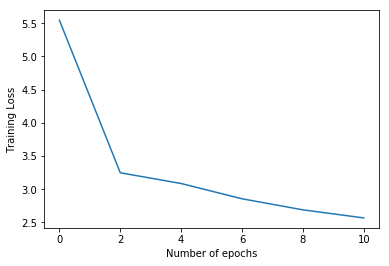

In [61]:
import matplotlib.pyplot as plt
plt.plot([0,2,4,6,8,10],[5.544362778371761,3.248017773785678,3.0862035616639205,2.85652777743687,2.6897452115973324,2.568352869866591])
plt.xlabel("Number of epochs")
plt.ylabel("Training Loss")
plt.show()

## Answer 2(c)

In [39]:
def predict_text(model, s, t):
    c = np.array([ohe(a) for a in s])
    for i in range(len(c)):
        print(chr(np.argmax(c[i])), end='')
    for i in range(500):
        c = model.predict_prob(c, t)
        c = np.array([ohe(chr(a)) for a in c])
        print(chr(np.argmax(c[-1])), end='')
    print('')


In [40]:
predict_text(model, 'a', 1)

¡ÈH6³IåÚâÕØQ«2-ÍKg^¸2]ò>M­ÿXÎ¯LA
|."¾8sÏÁ>bÜmÞÉ?d^¦WÊ13ÏÀÿ±­´ß½AàÒ®KJËþU©þ¥ø¥þãà{¡Ïn@Ü-±
R/-unö¥d+íIRLµ~u<"MÙðh'È7AÐ ñìýx²k&¸Ì]¯rË³12	[éy'p¢É§IHð¿¶ÌºÍí-ÚÎ sr-ÍôyWÁrt..
°ÍàPÁÀLÅjzNÞ¶KÐ_,õQâDÝÏÿjëÅñlj:;cHæV¬Á¼ÕÉ×¦[ ÿYº[©?âqo sdKwÒWwÞÍE-çóÔw0ENoDIö
æç§Ü·'Uê%IQe<¼õ4^ó´¤*V'Ùê«[yÔ
cw\5$1]e
¯¸ïÀÚ'ÈED´Ëë®	§á]_<Fs3 f³û'rùº lg


In [41]:
predict_text(model, 'e', 1)

e6ÞGÎK4r-|´¥ÞË%8-[Ì>µïæ@æU$­Ê!%²OôÇ{Dh³Ý&×Þ#Ñ84Ì:ªKCü¡Ù fbu¾Ìm	8gYV8bXSÚ=k}A#(øÂl¹W×í.á:0Rïì"%úò1"·j¹l«!vzø&ºj
Ê&ÄÁIDÇ/Ïe uPË©8Q*èê4­¢xöÎ ìÈÁÞW][,9}5¶×'~³"©[_ÔÂÃ?}?ú_±XÄ°]=ëößKÁõÏÓR]¡Ô5JÆ ¸»WTÞUßQJ§DÏáÌ[Í)b_Z01ìòÏí)0+¶îmÁH_Ï¸5¯thR"|^ð&ogM_Y¯®vñ`ùßCÎiDDõõfZ*[Ó²âß¿Ä1)b¿4gß!ÖiÞ¬ 


In [42]:
predict_text(model, 'i', 1)

Òe`7#	ëuÌÌ¸ð°


In [43]:
predict_text(model, 'o', 1)

ofsgt/Á@Ýt4ýÓVb`²ÔÒ_¾Fm¹"Õê-¦NüÐ$Ø}ö¬Ñ, ie
Oâ&½?bj÷­­C'ßªÐ!y §ù:¦ñÛ °	¥óp÷êÔÚ¹>ëÞDêß±æ:à¬i¢8®`
ëÌNz£¤þ*\ä2=ê%#:«¢3*
ÙW{d<"L\wÔæØ¥9À[S{Ïe^vÊ6³÷ï£	òNì2ÈùÓ`XÒ#®th«{O_!Dç$O[i£ÌWøÂ«"Ê|N÷UÓÑ¦]3W>'®áßT;å¨RÆÅf¸gÃ²&}Û¬MnaD:´QÔúí¼á#¤ {õÇÊ¹Cêì³[ð\`õTgj	{×µ[3eÆngòù2¾	ýÀ;|!Ísdçy?¸ööàö|D2ûþ.ÞÓµJôS
	³Ðé~â¤¦`y¬T}>¨Æ±a1#ûÛæÃÒ	|áJ)EÍËÐÖ°¥GÝx0 êÖ¨¥÷¦ t c1xM


In [44]:
predict_text(model, 'u', 1)

uÜ¿Wè#VBqDf^±|[ùn_\¡öZÓÃÙ¤%ïyÐMáRL§¿3Ô=ð\øË°Î(
5jÊ<æÐ³âóa ¦g±GCµGsÏX|Æ¼Ù¬=ð þþ³ø¿>g»~}ûÌF ñll£y'è úö~xt¢ÃtqàQ:ÏøãàX­GÂ¯uX¶7hàP¢mâ£Å'ÔV}Ô«âdìßäI¼± F-B+
"Æqr÷¢Ã°ØaåØf·$ÆÚ¦RD¥QÆÒ4úè¾ÿ©)


In [46]:
predict_text(model, 'a', 0.1)

athe the the the s the the cathe the the the she the ce the the the she s sathe the the the the the the she cathe the she the the she she she the she the the the cathe n the the the the she the the the athe the the cathe the cathe she cathe the the n the the the the the the sathe sathe cathe sathe the the the the the the the the the the the the the the the the the the the the she the the the sathe the the cathe the the the the the the the the the the the the she cathe the sathe the the the sathe 


In [47]:
predict_text(model, 'e', 0.1)

e the the the the the the the she she the cathe the cathe sathe the she the the the she the the the the the the the the the the she cathe the s she the the the the the the she the the the cathe the she she she the the the the s sathe the she the she the sathe the the the the the the the the the the she the the the the n cathe the the the the the the the thathe the the the the she she she she the the sathe s she the the she sathe she she the the the we the the cathe the the she n she the the the t


In [48]:
predict_text(model, 'i', 0.1)

ithe the cuthe the the she the the sathe the the she the cathe the she the the cathe the the sathe the the she the she the the sathe the the the the she she the the the the the the cathe the ckouthe she the the the the she she the the the the the the the athe she the she cathe she the cithe the the the the the athe we the the she the sathe the cathe she the the the the the the cathe the the the the the she the athe cathe the the she she she the cathe the sathe the she the sathe the the the she sa


In [49]:
predict_text(model, 'o', 0.1)

outhe she the the the she the the the she the n the the the the she she she the the the the the the she she she the sathe the the the the the the the the the she the the the the she the the cathe the the sathe the the cathe the the the she the the the the she s the the she the she she cithe the s the the the cathe the the the the she cathe sathe the the the cathe the the t the the the the n the she the the she cathe the cathe the sathe the the s the she the the the the cothe the the the the the s


In [50]:
predict_text(model, 'u', 0.1)

uthe the she the the she the sathe the the cathe the the the the the sathe the the the the the the cathe she the the she the the the the sathe the the she she the she the n she cathe she the the we sathe cathe the she sathe she the she the the the sathe the the the cathe the the t the the the the she sathe the cathe cathe the the the cathe she the she the cathe she the the she the the she the the cathe the the she she cathe the cathe cathe con the the the cathe the cathe sothe cathe the she the t


In [51]:
predict_text(model, 'a', 10)

÷"®¥6Â¶²DÚ|db©r»âM!í-L?xMùWuÄ@Ø:ß)r2Kî7e¢Ö8Pf\fÉI :î¼Ò3~^UðCÓØ"k>ÌÆ®1
®½ùýÔft. ×[y*÷Ë³#LF¶ÌSÛý[³´êb²IÄÅ¯wJ"ÄÕJ;eÆq×~úúOy·9 1=PÆ&0G'\7£Ç±df&I
bè¡IâI®ÏußÜhó[D)m¹àÌ¹>+hê(¢Æ«	¤,{,ü¡Ìé
D0è°a!±ªCÃ;vì?÷ |&7¥Utµ÷Úè4¥Bß/Ú[ýÍu¶§(ÙOGFáòÉð_ýO$ü¡ØÏúl2	\¥æ
ô]ºb¹jÖûµ5x;æ"ÒòtÐtÉ§»à*ÊT²8¾Rj¸0}ziFïjR)Eònß¿¿ÞpoÌ2ëò7 I¿
1	ï _I¨¬ÈõÁ5Â¯Î;ª´ó¥0!!³+c²AÜÞÅÒÑ


In [53]:
predict_text(model, 'e', 10)

e¬ËÞkù×=uèZY`d4¥?mm8ûz&Àx¤ðOþP£õujYâÅÎî°$+É§EL=ðh3§TöÈsrd½ÔÚ«#¼.-F§_Û /QÊ]H¦MvVP,JB	2¥;(LA<Æ®?GA½ Ãèk'n,ßoÈàHr7 ®©ÒÙQIþâD¼&z?¦/7/¾}Ûtb¼å8«èé8ÂÝ8/
ÃÍ·ÞæsiB~?Xî¦lkhh¼¿;<y(Ç
ÊËfÍÎÑ¡%Ó@$`øÃJGª va;´\üS¶0ÃLÄpW'ø@ìTSó\?}yæ¿Í=e=ÂzÆ:ióÑt´× -ãÛÖ©>ï²N%O4EjÖ3Êò¬,Å9d
Ú$~vÅÃ­AE·æ`ZÐY?ÛdsàÞÈÓdá~Èõ¤.ÐUm'¥¥ÂÏÇ§lñæìÕõO[¸Ãài?N¿1þÙe¹§QKÉ§½ÄOèdAße:¼¦·ËlGÁ¦ñ,Ë=/üu³þVöGÅhÍÓ
~çºGNe¢&´ê}xÓ.Bü¨ÍÕ


In [54]:
predict_text(model, 'i', 10)

¾åë<¯ã&ßQñ Ûeß·ybXÏAMN@ó¹#§ Qe;¤×÷WÒåÑDÔVLéÂ79ÊÖ/¨n:³-T5®	o/¨H¡ÕÎÑi.÷Çò¬`ËôfÄ8!3³ö{zé "ÿmD=ÓjÏi ª¦×ãn}(ó8_Á gûÓ/2ç®¯åOÀ±óñc;TD]ÏÄ¡+É¯eÝÇcAÉEýË>pU1³V¦ªÏ«nu Ùü"Ë^´dÊmçÆkÐ?¼Ü>¡oNû<=ÛcsC£nï\ÓÁ¾e[4rúÅDæv-¡ÉàÆÄ±%Ûgé(.gUqÿÊRYD'Å,uÖc*º'û_2ÂàálÃJwÏº ¬E_1Ôt&p¢EÉ!µjÈ¢ªÍ¹]Ö)


In [55]:
predict_text(model, 'o', 10)

onß$¬ê©fÉÈæ®UÍî|<èÁÞµÕmdFd¹ÕæÕ1©F4õÏVËU^¹¨Ý*M¢ØQ»®&´Û¾¿~ò ç¾ìÏ¼²%Ì
ërcÊï¯+¯,;þk&P²kûí¢ü;ç	/¸Ø¾>qè¢J¢¹¥G1¬¤6Ä³±ñ<ôÃÌ?­Y>Ü_!ðÒíÑYæ2î~1RBügZþµÃ(@ÓÆÏ(bÒutºû£äd¡ü|¿¹ö¤;ñÙ J1ÁóitL¢>§ÕuýkàqîxN°]O>*ç)BÀÂ'rø vóO'Áb×
úÁ£äæëÞ=ád½êûÿ0Q¨<A^Ü±±Z«6Üèf	Æ
ÙÄ&;ÇvìÝ®¡æJÚB2.Í±¡È)LZéÓÇÞAÆ_/h«ÜôÿbÏzý"å»ÒnC.«¤á`(9\Hµ£._Ðê Ù_VËRIQqþñþDÂ¡|ú¢wYZn
lpàPØ-´Poíë.ôÔ¥aÞÞª¯ùµ¢.y(ºlÓTz­ü¡ûvörðMmì.yp²rÁæ½ê©×Ç RÝçCM±


In [56]:
predict_text(model, 'u', 10)

u`NxØ¼È.	¸2¨Xæ.!w7XªáÕÑ¶eÇ(ôuBÃ¼V`g) ¸ðD°6É kÊ÷ AÏÀ)Íú»jré7oá£8ÆjcÔ²§Ó¢£ÞÅqó+_±1øäØ½fY°+IPþãVQS-i«·©Ø Hh<ÆO.±w²õú8g°
áÙá¡WðªA~$Ô¶ýÑÀ6D{8r@rò65^§8ï½b¹+ÙÖj*Jm­þp2»|qÊ|	*×Z i÷hµþ
iÃÏ~f¥Òu©ßPÞ3y>­dú»ÙÿîNx[
¢\é,Ù±)­>Á»z¾¡"¥³t¾7}+´gË ¨Ùªz§RïÉ^êá}ØÝ¯+ÖJìl§xª¤¼-=R[¾*Äbø±·¤Å¨#QfZòÔð¥OB»l"x¤oãJ:¼ÃíÍ.§6­#ä¥²A®üZªçjtìØ5


## Observations from 2(c)

1. I have predicted the text generated from a, e, i, o, u for temperatures 0.1, 1, 10
2. For temperature as `0.1` it performs better whereas with high temperatures, it predicts random strings